In [258]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import skfuzzy as fuzz
import pandas as pd
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer
import prince

In [259]:
rfm_df = pd.read_csv('../datasets/Pakistan_Ecommerce/rfm.csv')
embedding_df = pd.read_csv('../datasets/Pakistan_Ecommerce/rfm_embedding.csv')

In [260]:
def get_pca_2d(df, predict):
    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
        n_components=3,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [261]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,1.0,0.027553,0.075592,-0.004154,0.032484,-0.018314,-0.041990,0.028784,0.015180,-0.008948,...,0.000961,-0.043752,-0.020272,0.007038,-0.007795,0.027966,-0.019098,0.039021,0.000568,0.019237
1,3.0,0.018404,0.060627,-0.004330,0.024581,-0.035879,-0.048666,-0.019052,0.029558,-0.016038,...,0.022971,-0.025133,-0.010234,0.003425,-0.010827,0.001008,0.012684,0.048591,-0.014719,0.017675
2,4.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
3,6.0,0.027553,0.075592,-0.004154,0.032484,-0.018314,-0.041990,0.028784,0.015180,-0.008948,...,0.000961,-0.043752,-0.020272,0.007038,-0.007795,0.027966,-0.019098,0.039021,0.000568,0.019237
4,7.0,0.025606,0.062882,-0.004133,0.034055,-0.027723,-0.046881,0.020611,0.019658,-0.014579,...,0.009746,-0.035312,-0.019050,0.008660,-0.008685,0.036232,-0.014210,0.048493,0.001722,0.020490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62285,115218.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62286,115267.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62287,115276.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839


In [262]:
rfm_df

,Customer ID,Recency,RecencyScore,RecencyScoreText,Frequency,FrequencyScore,FrequencyScoreText,MonetaryValue,MonetaryScore,MonetaryScoreText
0,1.0,789,1,a very long time ago,1,1,extremely rarely,1950.0,1,only a very little money
1,3.0,467,3,no so recently,4,1,extremely rarely,1245.0,1,only a very little money
2,4.0,2,5,very recently,261,1,extremely rarely,1445579.0,1,only a very little money
3,6.0,789,1,a very long time ago,1,1,extremely rarely,170.0,1,only a very little money
4,7.0,501,2,some time ago,4,1,extremely rarely,1939.0,1,only a very little money
...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,4,5,very recently,3,1,extremely rarely,9029.0,1,only a very little money
62285,115218.0,3,5,very recently,1,1,extremely rarely,600.0,1,only a very little money
62286,115267.0,2,5,very recently,3,1,extremely rarely,1397.0,1,only a very little money
62287,115276.0,2,5,very recently,2,1,extremely rarely,3749.0,1,only a very little money


Outliers

In [263]:
rfm_copy = rfm_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]]
rfm_copy

,RecencyScore,FrequencyScore,MonetaryScore
0,1,1,1
1,3,1,1
2,5,1,1
3,1,1,1
4,2,1,1
...,...,...,...
62284,5,1,1
62285,5,1,1
62286,5,1,1
62287,5,1,1


In [264]:
rfm_df

,Customer ID,Recency,RecencyScore,RecencyScoreText,Frequency,FrequencyScore,FrequencyScoreText,MonetaryValue,MonetaryScore,MonetaryScoreText
0,1.0,789,1,a very long time ago,1,1,extremely rarely,1950.0,1,only a very little money
1,3.0,467,3,no so recently,4,1,extremely rarely,1245.0,1,only a very little money
2,4.0,2,5,very recently,261,1,extremely rarely,1445579.0,1,only a very little money
3,6.0,789,1,a very long time ago,1,1,extremely rarely,170.0,1,only a very little money
4,7.0,501,2,some time ago,4,1,extremely rarely,1939.0,1,only a very little money
...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,4,5,very recently,3,1,extremely rarely,9029.0,1,only a very little money
62285,115218.0,3,5,very recently,1,1,extremely rarely,600.0,1,only a very little money
62286,115267.0,2,5,very recently,3,1,extremely rarely,1397.0,1,only a very little money
62287,115276.0,2,5,very recently,2,1,extremely rarely,3749.0,1,only a very little money


In [265]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

# Unsupervised Outlier Detection Using Empirical Cumulative Distribution Functions (ECOD)
clf = ECOD()
clf.fit(rfm_copy)

out = clf.predict(rfm_copy) 
rfm_df["outliers"] = out
# rfm_df["outliers"] = out

rfm_df_no_out = rfm_df[rfm_df["outliers"] == 0]
rfm_df_no_out = rfm_df_no_out.drop(["outliers"], axis = 1)

rfm_with_out = rfm_df.copy()
rfm_with_out = rfm_with_out.drop(["outliers"], axis = 1)


In [266]:
rfm_df_no_out.shape

(60612, 10)

In [267]:
rfm_with_out

,Customer ID,Recency,RecencyScore,RecencyScoreText,Frequency,FrequencyScore,FrequencyScoreText,MonetaryValue,MonetaryScore,MonetaryScoreText
0,1.0,789,1,a very long time ago,1,1,extremely rarely,1950.0,1,only a very little money
1,3.0,467,3,no so recently,4,1,extremely rarely,1245.0,1,only a very little money
2,4.0,2,5,very recently,261,1,extremely rarely,1445579.0,1,only a very little money
3,6.0,789,1,a very long time ago,1,1,extremely rarely,170.0,1,only a very little money
4,7.0,501,2,some time ago,4,1,extremely rarely,1939.0,1,only a very little money
...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,4,5,very recently,3,1,extremely rarely,9029.0,1,only a very little money
62285,115218.0,3,5,very recently,1,1,extremely rarely,600.0,1,only a very little money
62286,115267.0,2,5,very recently,3,1,extremely rarely,1397.0,1,only a very little money
62287,115276.0,2,5,very recently,2,1,extremely rarely,3749.0,1,only a very little money


In [268]:
rfm_df_no_out[["Recency", "Frequency", "MonetaryValue"]]

,Recency,Frequency,MonetaryValue
0,789,1,1950.0
1,467,4,1245.0
3,789,1,170.0
4,501,4,1939.0
5,789,1,5500.0
...,...,...,...
61332,159,5,21877.0
61333,159,1,4733.0
61334,159,6,3509.0
61339,159,1,15833.0


In [269]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rfm_df_no_out_scaled = scaler.fit_transform(rfm_df_no_out[["Recency", "Frequency", "MonetaryValue"]])
rfm_df_no_out_scaled = pd.DataFrame(rfm_df_no_out_scaled, columns = ["Recency", "Frequency", "MonetaryValue"])


In [270]:
rfm_df_no_out[["Recency", "Frequency", "MonetaryValue"]]

,Recency,Frequency,MonetaryValue
0,789,1,1950.0
1,467,4,1245.0
3,789,1,170.0
4,501,4,1939.0
5,789,1,5500.0
...,...,...,...
61332,159,5,21877.0
61333,159,1,4733.0
61334,159,6,3509.0
61339,159,1,15833.0


In [271]:
n_clusters = 5

In [272]:
from fcmeans import FCM
rfm_df_no_out_array = rfm_df_no_out_scaled.to_numpy()  # Convert DataFrame to numpy array

fcm = FCM(n_clusters=n_clusters)
fcm.fit(rfm_df_no_out_array)

fcm_centers = fcm.centers
fcm_labels  = fcm.predict(rfm_df_no_out_array)

fcm_centers



array([[0.65053754, 0.00382526, 0.00245664],
       [0.35965828, 0.00727029, 0.00314736],
       [0.50188116, 0.00586047, 0.00327107],
       [0.18674073, 0.00796142, 0.00801621],
       [0.80936183, 0.00238623, 0.00195872]])

In [273]:
np.unique(fcm_labels)

array([0, 1, 2, 3, 4], dtype=int64)

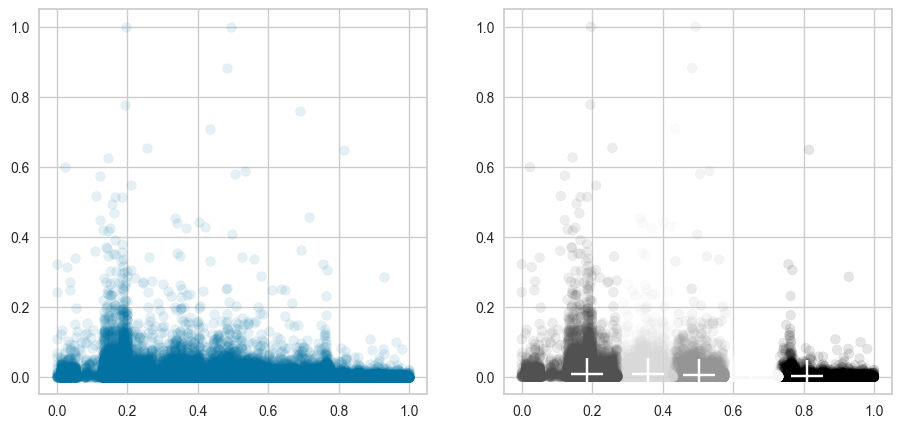

In [274]:
# plot the results
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(rfm_df_no_out_array[:,0], rfm_df_no_out_array[:,1], alpha=.1)
axes[1].scatter(rfm_df_no_out_array[:,0], rfm_df_no_out_array[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
plt.show()



In [275]:
n_clusters_list = [2, 3, 4]
models = list()
for n_clusters in n_clusters_list:
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(rfm_df_no_out_array)
    models.append(fcm)

n_clusters = 2, PC = 0.435, PEC = 0.158, silhouette = 0.654, calinski = 205053.662, davies = 0.462, inertia = 9374.193
n_clusters = 3, PC = 0.281, PEC = 0.139, silhouette = 0.645, calinski = 280028.203, davies = 0.454, inertia = 11004.687
n_clusters = 4, PC = 0.204, PEC = 0.132, silhouette = 0.625, calinski = 304766.429, davies = 0.504, inertia = 252.541


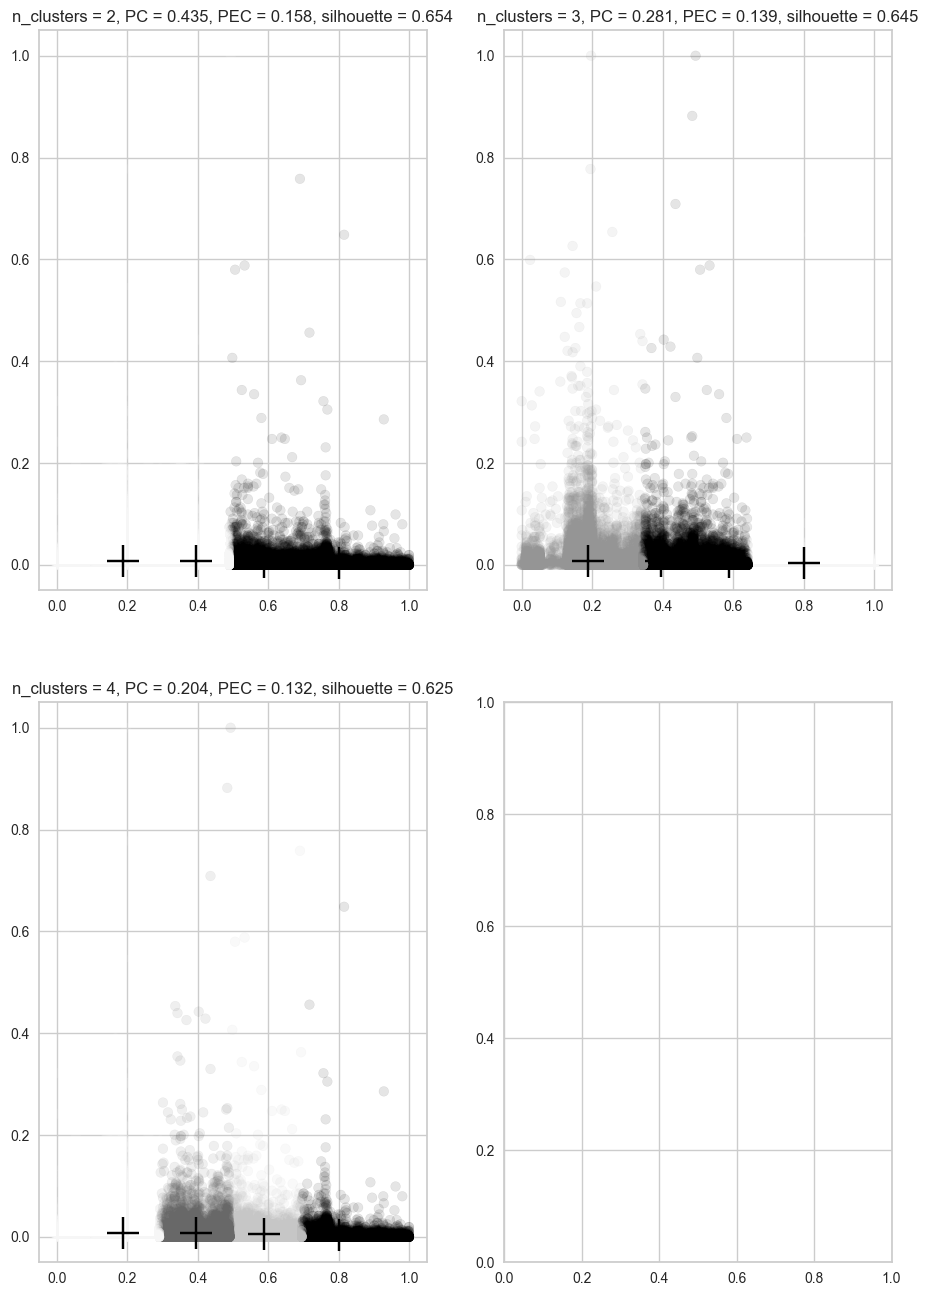

In [278]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# outputs
num_clusters = len(n_clusters_list)
rows = int(np.ceil(np.sqrt(num_clusters)))
cols = int(np.ceil(num_clusters / rows))

f, axes = plt.subplots(rows, cols, figsize=(11,16))
for n_clusters, model, axe in zip(n_clusters_list, models, axes.ravel()):
    # get validation metrics
    pc = model.partition_coefficient
    pec = model.partition_entropy_coefficient
    fcm_labels = model.predict(rfm_df_no_out_array)
    
    # Check if there is more than one unique label
    if len(np.unique(fcm_labels)) > 1:
        silhoutte = silhouette_score(rfm_df_no_out_array, fcm_labels)
        calsinki = calinski_harabasz_score(rfm_df_no_out_array, fcm_labels)
        davies = davies_bouldin_score(rfm_df_no_out_array, fcm_labels)
        inertia = 0
        for i, center in enumerate(fcm_centers):
            # Get points in this cluster
            cluster_points = rfm_df_no_out_array[fcm_labels == i]
            # Calculate distance of each point from the center
            distances = np.linalg.norm(cluster_points - center, axis=1)
            # Add squared distances to inertia
            inertia += np.sum(distances**2)
        fcm_centers = fcm.centers
        # plot result
        axe.scatter(rfm_df_no_out_array[:,0], rfm_df_no_out_array[:,1], c=fcm_labels, alpha=.1)
        axe.scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='black')
        axe.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhouette = {silhoutte:.3f}')
        print(f"n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhouette = {silhoutte:.3f}, calinski = {calsinki:.3f}, davies = {davies:.3f}, inertia = {inertia:.3f}")
    else:
        axe.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhouette = N/A (Only 1 label)')
        print(f"n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhouette = N/A (Only 1 label)")
plt.show()
    
    # # Check if there is more than one unique label
    # if len(np.unique(fcm_labels)) > 1:
    #     silhoutte = silhouette_score(rfm_df_no_out_array, fcm_labels)
        
    #     fcm_centers = model.centers
    #     # plot result
    #     axe.scatter(rfm_df_no_out_array[:,0], rfm_df_no_out_array[:,1], c=fcm_labels, alpha=.1)
    #     axe.scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='black')
    #     axe.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhoutte = {silhoutte:.3f}')
    #     print(f"n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhoutte = {silhoutte:.3f}")
    # else:
    #     axe.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhoutte = N/A (Only 1 label)')
    #     print(f"n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, silhoutte = {silhoutte:.3f}")
plt.show()

In [238]:
# average the RFM values of the clusters to get the general characteristics of the relevant customer segments
rfm_df_no_out["cluster"] = fcm_labels
rfm_df_no_out = rfm_df_no_out.groupby("cluster").agg({"Recency": "mean", "Frequency": "mean", "MonetaryValue": "mean"}).round(2)

rfm_df_no_out


,Recency,Frequency,MonetaryValue
cluster,,,
0,531.74,2.96,7948.87
1,414.95,3.96,8309.12
2,277.03,4.79,24711.03
3,666.41,2.00,4941.49


IndexError: list index out of range

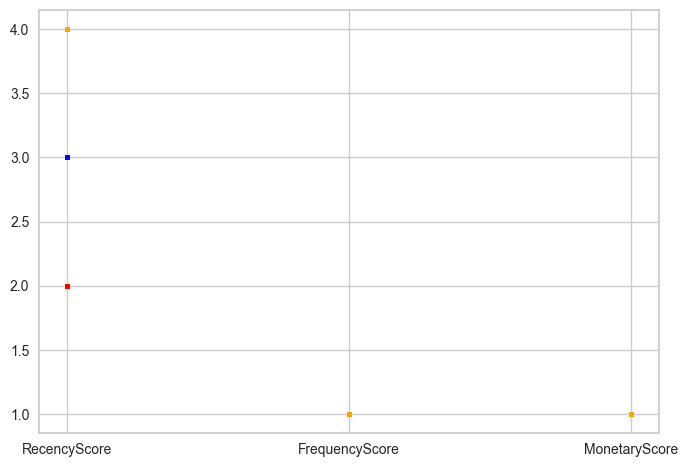

In [178]:
import skfuzzy as fuzz
from skfuzzy import cluster  # Import the cluster module separately

rfm_df_no_out_array = rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]].to_numpy()  # Convert DataFrame to numpy array

colors = ['red', 'blue', 'green', 'orange', 'purple']  # Define the colors for each cluster

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]].T, n_clusters, 2, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

# Plotting the results
fig1, ax1 = plt.subplots()
for j in range(n_clusters):
    ax1.plot(rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]][cluster_membership == j].T, '.',
             color=colors[j])
    
ax1.set_title('Trained model')
plt.show()






In [ ]:
# evaluate the model
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

silhouette_score(rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]], cluster_membership)



1.0

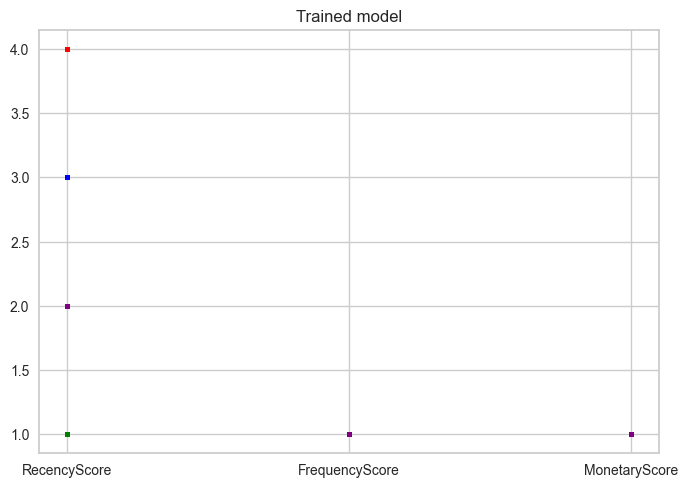

In [ ]:
from skfuzzy import cluster  # Import the cluster module separately
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Define the colors for each cluster

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]].T, n_clusters, 2, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

# Plotting the results
fig1, ax1 = plt.subplots()
for j in range(n_clusters):
    ax1.plot(rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]][cluster_membership == j].T, '.',
             color=colors[j])
    
ax1.set_title('Trained model')
plt.show()

In [ ]:
# evaluate the model
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

silhouette_score(rfm_df_no_out[["RecencyScore", "FrequencyScore", "MonetaryScore"]], cluster_membership)

1.0